### 0. Connect to your own google drive (option)

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
%cd /content/drive/MyDrive/Ganglin/1_IMT/MCE_Projet3A
# %cd /content

/content/drive/MyDrive/Ganglin/1_IMT/MCE_Projet3A


### 1. Initialization of notebook

In [6]:
!pip install pymodis -q
!pip install pymp-pypi -q

In [90]:
import os
import glob
from pymodis import downmodis
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import skimage.measure
import pymp
import time
# MOD13A2
# /content/drive/MyDrive/Ganglin/1_IMT/MCE_Projet3A/MODIS/MOD_2020_MOD13A2
hdfs_path           = 'MODIS/MOD_2020/hdfs_files'
npys_1km_path       = 'MODIS/MOD_2020/npys_files/1km'
npys_1km_Day_path   = 'MODIS/MOD_2020/npys_files/1km/Day'
npys_1km_Night_path = 'MODIS/MOD_2020/npys_files/1km/Night'
npys_4km_path       = 'MODIS/MOD_2020/npys_files/4km'
tifs_1km_path       = 'MODIS/MOD_2020/tifs_files/1km'
tifs_2km_path       = 'MODIS/MOD_2020/tifs_files/2km'

os.makedirs(hdfs_path,exist_ok=1)
os.makedirs(npys_1km_path,exist_ok=1)
os.makedirs(npys_1km_Day_path,exist_ok=1)
os.makedirs(npys_1km_Night_path,exist_ok=1)
os.makedirs(npys_4km_path,exist_ok=1)

os.makedirs(tifs_1km_path,exist_ok=1)
os.makedirs(tifs_2km_path,exist_ok=1)

### 2. Define utils

In [63]:
def norm4(a,axis):
  # result = np.zeros((np.array(a.shape)/2).astype(int))
  result = np.zeros([a.shape[0],a.shape[1]])
  for i in range(a.shape[0]):
    for j in range(a.shape[1]):
      non_0 = np.sum(a[i,j,:,:]!=0)
      if non_0 != 4:
        result[i,j] = 0
      else:
        result[i,j] = ((np.sum(a[i,j,:,:]**4))/non_0)**0.25

  return result


In [64]:
def sliding_window(img, step, window_size):
  """
  INPUT:
  img = input image
  step = the distance (in pixels, for both horizontal and vertical direction) 
  between 2 windows
  window_size = size of the sliding window, format: (pixels(y-axis),pixels(x-axis))

  OUTPUT: (x,y,window)
  x,y: the coordinates of the top left corner of the current window (in pixels) 
  in the coordinate system of "img".
  window: the current window, size = (window_size)
  """
  for y in range(0, img.shape[0], step):
    for x in range(0, img.shape[1], step):
      yield (x, y, img[y:y + window_size[1], x:x + window_size[0]])

In [65]:
def read_tif(in_file):
  """
  Similar to read_modis but this function is for reading output .tif file from
  """
  # save_tif()

  dataset =  gdal.Open(in_file, gdal.GA_ReadOnly)

  cols =dataset.RasterXSize
  rows = dataset.RasterYSize
  projection = dataset.GetProjection()
  geotransform = dataset.GetGeoTransform()

  # Coordinates of top left pixel of the image (Lat, Lon)
  coords=np.asarray((geotransform[0],geotransform[3]))

  # Open dataset Day as np.array()
  band = dataset.GetRasterBand(1)
  LST_K_day = band.ReadAsArray().astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  # open dataset Night as np.array()
  band = dataset.GetRasterBand(2)
  LST_K_night = band.ReadAsArray().astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  return LST_K_day,LST_K_night,cols,rows,projection,geotransform

def save_tif(out_file, LST_K_day, LST_K_night, cols, rows, projection, geotransform):
  """
  INPUT:
  out_file: directory + name of output tif file (e.g a/b/c/MOD11A1.tif)
  LST_K_day, LST_K_night, cols, rows, projection, geotransform: read read_modis

  OUTPUT:
  A .tif file having 2 bands(1 for day, 1 for night)
  """

  # Eliminate the clouds' pixel
  num_px = LST_K_day.shape[0]*LST_K_day.shape[1]
  thres = 0.15 # Threshold: maximum number of sea/cloud pixels
  if len(LST_K_day[LST_K_day==0.0]) > thres*num_px or len(LST_K_night[LST_K_night==0.0]) > thres*num_px:
    return False

  bands = 2
  day_night_imgs = np.zeros((2,LST_K_day.shape[0],LST_K_day.shape[1]))
  day_night_imgs[0,:,:]= LST_K_day
  day_night_imgs[1,:,:]= LST_K_night

  driver = gdal.GetDriverByName("GTiff")
  outDs = driver.Create(out_file, day_night_imgs.shape[1], day_night_imgs.shape[2], bands, gdal.GDT_Float32) 
  outDs.SetProjection(projection)
  outDs.SetGeoTransform(geotransform) 

  for i in range(1,bands+1):
    outBand = outDs.GetRasterBand(i)
    outBand.WriteArray(day_night_imgs[i-1,:,:])
    outDs.FlushCache()
    
  return True

In [66]:
def read_modis(in_file):
  """
  This function is for reading modis file in format "x.hdf" contained in 
  in_file parameter.
  INPUT: 
  in_file: path to hdf file
  to be completed if we need more stuffs

  OUTPUT:
  LST_K_day and LST_K_night: Day and Night LST image arrays
  cols, rows: numbers of pixels alongs x,y axes of each raster
  projection: projection information
  geotransform: georeferencing information
  # georef format = (x-coor top left pixel,resX,0,y-coor top left pixel,rexY,0)
  to be completed if we need more information (georeference,bands,etc.)
  """
  # open dataset Day
  dataset = gdal.Open(in_file,gdal.GA_ReadOnly)
  subdataset =  gdal.Open(dataset.GetSubDatasets()[0][0], gdal.GA_ReadOnly)

  cols =subdataset.RasterXSize
  rows = subdataset.RasterYSize
  projection = subdataset.GetProjection()
  geotransform = subdataset.GetGeoTransform()

  # Coordinates of top left pixel of the image (Lat, Lon)
  # coords=np.asarray((geotransform[0],geotransform[3]))

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  print("band",band,type(band))
  # bandtype = gdal.GetDataTypeName(band.DataType)

  # To convert LST MODIS units to Kelvin
  LST_K_day=0.02*LST_raw

  # open dataset Night
  dataset = gdal.Open(in_file,gdal.GA_ReadOnly)
  subdataset =  gdal.Open(dataset.GetSubDatasets()[4][0], gdal.GA_ReadOnly)

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  # bandtype = gdal.GetDataTypeName(band.DataType)
  print("band",band,type(band))

  # To convert LST MODIS units to Kelvin
  LST_K_night=0.02*LST_raw

  # return LST_K_day, LST_K_night
  return LST_K_day, LST_K_night, cols, rows, projection, geotransform


def crop_modis(hdf_path, hdf_name, save_dir, save_dir_downsample,step=64,size=(64,64)):
  """
  INPUT:
  hdf_path = input image path to be cropped | or hdf file path ("/a/b/c.hdf")
  save_dir = directory for saving cropped images
  step, size: parameters of "sliding_window()"

  OUTPUT: images cropped from the image in hdf_path, saved to save_dir
  """
  if not hdf_path.endswith('hdf'): 
    print("Not hdf file Sorry!")
    return 

  img_day, img_night, cols, rows, projection, geotransform = read_modis(hdf_path)
  
  img_days = []
  img_nights = []
  img_cropped_names = []
  geotransform2s = []
  cols2, rows2 = size

  if img_day is None or img_night is None:
    print("Cannot handle this MODIS file: ", hdf_path, ". Please check it again")
    return
  # For day image
  win_count = 0
  for (x,y,window) in sliding_window(img_day, step, size):
      if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue

      img_cropped_name = hdf_name + ".{}.tif".format(str(win_count).zfill(4))
      img_cropped = window
      geotransform2 = np.asarray(geotransform)
      geotransform2[0] = geotransform[0]+x*geotransform[1] # 1st coordinate of top left pixel of the image 
      geotransform2[3] = geotransform[3]+y*geotransform[5] # 2nd coordinate of top left pixel of the image
      geotransform2=tuple(geotransform2)

      img_cropped_names.append(img_cropped_name)
      img_days.append(img_cropped)
      geotransform2s.append(geotransform2)
      
      win_count += 1
  # print("Number of cropped day images", win_count)

  # For night image
  win_count = 0
  for (x,y,window) in sliding_window(img_night, step, size):
    if window.shape[0] != size[0] or window.shape[1] != size[1]:
        continue
    # save_path = os.path.join(save_dir,img_cropped_name)
    img_cropped = window
    # np.save(save_path,img_cropped)
    img_nights.append(img_cropped)
    win_count += 1
  # print("Number of cropped night images", win_count)
  
  # Save images and metadata into .tif file
  for i in range(len(img_cropped_names)):
    save_path = os.path.join(save_dir,img_cropped_names[i])
    succes = save_tif(save_path, img_days[i], img_nights[i], cols2, rows2, projection, geotransform2s[i])

    if succes:
      save_path_downsample = os.path.join(save_dir_downsample,img_cropped_names[i])
      img_day_downsample = skimage.measure.block_reduce(img_days[i],(2,2),norm4)
      img_night_downsample = skimage.measure.block_reduce(img_nights[i],(2,2),norm4)
      _ = save_tif(save_path_downsample, img_day_downsample, img_night_downsample, cols2, rows2, projection, geotransform2s[i])

      # print("img_night_downsample",img_night_downsample)
      # # Display image
      # tif_1km_path = save_path
      # tif_2km_path = save_path_downsample
      # LST_K_day_1km, LST_K_night_1km, cols_1km, rows_1km, projection_1km, geotransform_1km = read_tif(tif_1km_path)
      # LST_K_day_2km, LST_K_night_2km, cols_2km, rows_2km, projection_2km, geotransform_2km = read_tif(tif_2km_path)

      # plt.figure()
      # plt.subplot(121)
      # plt.imshow(LST_K_day_1km)
      # plt.clim(260,301)
      # plt.colorbar()
      # plt.title("1km")
      # plt.subplot(122)
      # plt.imshow(LST_K_day_2km)
      # plt.clim(260,301)
      # plt.colorbar()
      # plt.title("2km")
      # plt.show()

In [67]:
def cloud_sea_eliminate(tifs_folder):
  """
  INPUT
  dir: the directory containing cropped TIF file from which we want to eliminate 
  the ones having cloud and sea

  OUTPUT
  there is not any output, just the images containing cloud or sea pixels (>15% the number of pixels)  
  will be eliminated from the directory
  """
  tifs = os.listdir(tifs_folder)

  for i,tif in enumerate(tifs):
    if not tif.endswith('tif'): continue
    tif_path = os.path.join(tifs_folder, tif)
    LST_K_day, LST_K_night, cols, rows, projection, geotransform = read_tif(tif_path)
    num_px = cols*rows
    thres = 0.15 # Threshold: maximum number of sea/cloud pixels
    if len(LST_K_day[LST_K_day==0.0]) > thres*num_px or len(LST_K_night[LST_K_night==0.0]) > thres*num_px:
      os.remove(tif_path)
      print("Too much cloud or sea pixels! Remove: {}".format(tif_path))

### 3. Download Raw MODIS Dataset

In [68]:

# # tiles to download, France is in h17v04 and h18v04 
# tiles = "h18v04" # string of tiles separated by comma
# year = 2020
# # product names ("MOD11A1.061" and "MYD11A1.061") Example (Carlos sent us) "MOD11A1.A2021274.h18v04.061.2021278094039.hdf" ; "MOD11A1 v061 - LP DAAC" and "MYD11A1 v061 - LP DAAC"
# products = "MOD13A2.061" # product name as on the http/ftp server
#                          # https://modis.gsfc.nasa.gov/data/dataprod/mod13.php

# # Download data with multi-core
# startdate = "2020-01-01" 
# enddate = "2020-01-02" 
# print("start download From {} to {}".format(startdate,enddate))
# modisDown = downmodis.downModis(user="projet3a",password="Projet3AIMT",product=products,destinationFolder=hdfs_path, tiles=tiles, today=startdate, enddate=enddate)
# modisDown.connect()
# modisDown.downloadsAllDay()

In [69]:
# tiles to download, France is in h17v04 and h18v04 
tiles = "h18v04" # string of tiles separated by comma
year = 2020
# product names ("MOD11A1.061" and "MYD11A1.061") Example (Carlos sent us) "MOD11A1.A2021274.h18v04.061.2021278094039.hdf" ; "MOD11A1 v061 - LP DAAC" and "MYD11A1 v061 - LP DAAC"
products = "MOD13A2.061" # product name as on the http/ftp server
# products = "MOD11A1.061" # product name as on the http/ftp server

# Download data with multi-core
num_threads = 4
with pymp.Parallel(num_threads) as p:
  for month in p.range(1, 13):
    startdate = "{}-{}-01".format(str(year),str(month).zfill(2))
    if month != 12: 
      enddate = "{}-{}-01".format(str(year),str(month+1).zfill(2))
    else:
      enddate = "{}-{}-31".format(str(year),str(month).zfill(2))

    print("start download From {} to {}".format(startdate,enddate))
    modisDown = downmodis.downModis(user="projet3a",password="Projet3AIMT",product=products,destinationFolder=hdfs_path, tiles=tiles, today=startdate, enddate=enddate)
    modisDown.connect()
    modisDown.downloadsAllDay()

start download From 2020-04-01 to 2020-05-01
start download From 2020-10-01 to 2020-11-01
start download From 2020-07-01 to 2020-08-01
start download From 2020-01-01 to 2020-02-01
start download From 2020-05-01 to 2020-06-01
start download From 2020-11-01 to 2020-12-01
start download From 2020-02-01 to 2020-03-01
start download From 2020-08-01 to 2020-09-01
start download From 2020-12-01 to 2020-12-31
start download From 2020-03-01 to 2020-04-01
start download From 2020-06-01 to 2020-07-01
start download From 2020-09-01 to 2020-10-01


### 4. Crop image and save as tif format

In [25]:
hdfs = os.listdir(hdfs_path)
hdfs.sort()
start_time = time.time()
# Core images with multi-core
num_threads = 4
with pymp.Parallel(num_threads) as p:
  for index in p.range(0, len(hdfs)):
    hdf = hdfs[index]
    if not hdf.endswith('hdf'): continue
    hdf_path = os.path.join(hdfs_path,hdf)
    crop_modis(hdf_path, hdf,tifs_1km_path, tifs_2km_path, 64, (64,64))
print("Using {}s to process data".format(time.time()-start_time))
# cloud_sea_eliminate(tifs_2km_path)

hdf_path MODIS/MOD_2020/hdfs_files/MOD13A2.A2020001.h18v04.061.2020326033640.hdf
band <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f8ef03e63f0> > <class 'osgeo.gdal.Band'>
band <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f8ef03e65a0> > <class 'osgeo.gdal.Band'>
Using 16.311452627182007s to process data


tif_1km_path MODIS/MOD_2020/tifs_files/1km/MOD13A2.A2020001.h18v04.061.2020326033640.hdf.0172.tif


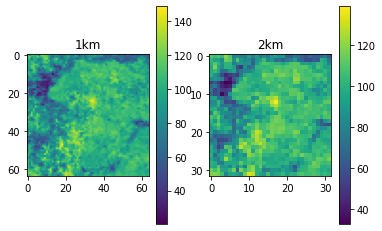

tif_1km_path MODIS/MOD_2020/tifs_files/1km/MOD13A2.A2020001.h18v04.061.2020326033640.hdf.0304.tif


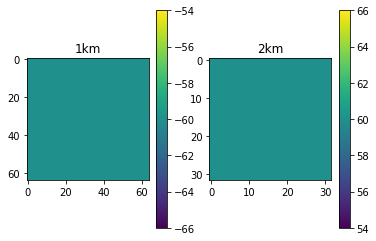

tif_1km_path MODIS/MOD_2020/tifs_files/1km/MOD13A2.A2020001.h18v04.061.2020326033640.hdf.0216.tif


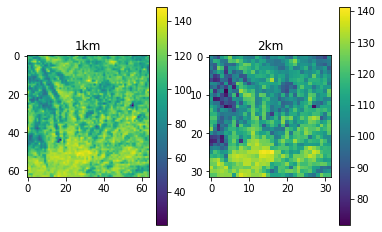

tif_1km_path MODIS/MOD_2020/tifs_files/1km/MOD13A2.A2020001.h18v04.061.2020326033640.hdf.0095.tif


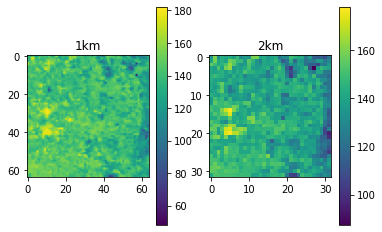

tif_1km_path MODIS/MOD_2020/tifs_files/1km/MOD13A2.A2020001.h18v04.061.2020326033640.hdf.0173.tif


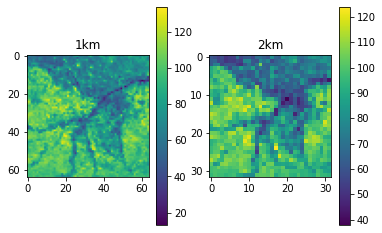

tif_1km_path MODIS/MOD_2020/tifs_files/1km/MOD13A2.A2020001.h18v04.061.2020326033640.hdf.0101.tif


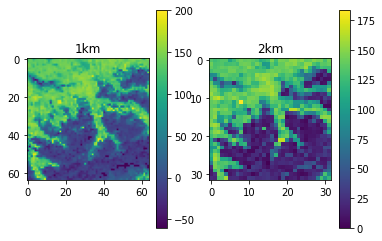

In [19]:
tifs = os.listdir(tifs_1km_path)

for i,tif in enumerate(tifs):
  if i>5: break # just for demo
  if not tif.endswith('tif'): continue
  tif_1km_path = os.path.join(tifs_1km_path, tif)
  tif_2km_path = os.path.join(tifs_2km_path, tif)
  # print("tif_1km_path",tif_1km_path)
  LST_K_day_1km, LST_K_night_1km, cols_1km, rows_1km, projection_1km, geotransform_1km = read_tif(tif_1km_path)
  LST_K_day_2km, LST_K_night_2km, cols_2km, rows_2km, projection_2km, geotransform_2km = read_tif(tif_2km_path)

  plt.figure()
  plt.subplot(121)
  plt.imshow(LST_K_day_1km)
  # plt.clim(260,301)
  plt.colorbar()
  plt.title("1km")
  plt.subplot(122)
  plt.imshow(LST_K_day_2km)
  # plt.clim(260,301)
  plt.colorbar()
  plt.title("2km")
  plt.show()
plt.close()

### 5. Extract image array to npy

In [ ]:
hdfs = os.listdir(hdfs_path)

for hdf in hdfs:
  if not hdf.endswith('hdf'): continue

  hdf_path = os.path.join(hdfs_path,hdf)
  print("hdf_path",hdf_path)
  # open dataset Day
  dataset = gdal.Open(hdf_path,gdal.GA_ReadOnly)
  subdataset =  gdal.Open(dataset.GetSubDatasets()[0][0], gdal.GA_ReadOnly)

  cols =subdataset.RasterXSize
  rows = subdataset.RasterYSize
  projection = subdataset.GetProjection()
  geotransform = subdataset.GetGeoTransform()

  # Coordinates of top left pixel of the image (Lat, Lon)
  coords=np.asarray((geotransform[0],geotransform[3]))

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  # To convert LST MODIS units to Kelvin
  LST_K_day=0.02*LST_raw

  # plt.figure(figsize=(50,50))
  # plt.imshow(LST_K_day)
  # plt.clim(260,301)
  # plt.colorbar()

  # open dataset Night
  dataset = gdal.Open(hdf_path,gdal.GA_ReadOnly)

  subdataset =  gdal.Open(dataset.GetSubDatasets()[4][0], gdal.GA_ReadOnly)

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  # To convert LST MODIS units to Kelvin
  LST_K_night=0.02*LST_raw

  # plt.figure(figsize=(50,50))
  # plt.imshow(LST_K_night)
  # plt.clim(260,301)
  # plt.colorbar()

  npy_path = os.path.join(npys_1km_path,"Day",hdf)
  np.save(npy_path,LST_K_day)
  npy_path = os.path.join(npys_1km_path,"Night",hdf)
  np.save(npy_path,LST_K_night)


hdf_path dataset/hdfs_files/MOD11A1.A2020002.h18v04.061.2021003094902.hdf
hdf_path dataset/hdfs_files/MOD11A1.A2020001.h18v04.061.2021003092415.hdf


### 6. Demo

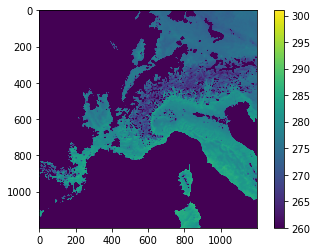

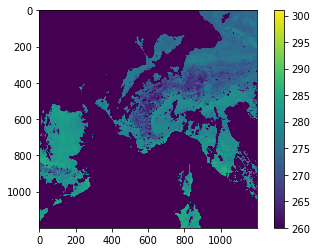

In [ ]:

imgs = os.listdir(npys_1km_Day_path)

for img in imgs:
# if 1:
  # img = imgs[0]
  # Load Day npy file
  npy_path = os.path.join(npys_1km_Day_path,img)
  LST_K_day = np.load(npy_path)

  plt.figure()
  plt.imshow(LST_K_day)
  plt.clim(260,301)
  plt.colorbar()

### 7. Show dataset structure

In [ ]:
!apt install tree
!tree dataset

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
dataset
├── hdfs_files
│   ├── listfileMOD11A1.061.txt
│   ├── MOD11A1.A2020001.h18v04.061.2021003092415.hdf
│   ├── MOD11A1.A2020001.h18v04.061.2021003092415.hdf.xml
│   ├── MOD11A1.A2020002.h18v04.061.2021003094902.hdf
│   ├── MOD11A1.A2020002.h18v04.061.2021003094902.hdf.xml
│   └── modisMOD11A1.061.log
├── npys_files
│   ├── 1km
│   │   ├── Day
│   │   │   ├── MOD11A1.A2020001.h18v04.061.2021003092415.hdf.npy
│   │   │   └── MOD11A1.A2020002.h18v04.061.2021003094902.hdf.npy
│   │   └── Night
│   │       ├── MOD11A1.A2020001.h18v04.061.2021003092415.hdf.npy
│   │       └── MOD11A1.A2020002.h18v04.061.2021003094902.hdf.npy
│   └── 4km
└── tifs_files
    ├── 1km
    │   ├── MOD11A1.A2020001.h18v04.061.2021003092415.hdf.0013.tif
    │   ├── MOD11A1.A2020001.h18v04.061.2021003092415.h

In [ ]:
len(os.listdir("/content/drive/MyDrive/Ganglin/1_IMT/MCE_Projet3A/MODIS/MOD_2020/tifs_files/1km"))

13802

## test NDVI

In [97]:
%cd /content/drive/MyDrive/Ganglin/1_IMT/MCE_Projet3A

import os
import glob
from pymodis import downmodis
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import skimage.measure
import pymp
import time
# MOD13A2
# /content/drive/MyDrive/Ganglin/1_IMT/MCE_Projet3A/MODIS/MOD_2020_MOD13A2
hdfs_path           = 'MODIS/MOD_2020_MOD13A2/hdfs_files'
npys_1km_path       = 'MODIS/MOD_2020_MOD13A2/npys_files/1km'
npys_1km_Day_path   = 'MODIS/MOD_2020_MOD13A2/npys_files/1km/Day'
npys_1km_Night_path = 'MODIS/MOD_2020_MOD13A2/npys_files/1km/Night'
npys_4km_path       = 'MODIS/MOD_2020_MOD13A2/npys_files/4km'
tifs_1km_path       = 'MODIS/MOD_2020_MOD13A2/tifs_files/1km'
tifs_2km_path       = 'MODIS/MOD_2020_MOD13A2/tifs_files/2km'

os.makedirs(hdfs_path,exist_ok=1)
os.makedirs(npys_1km_path,exist_ok=1)
os.makedirs(npys_1km_Day_path,exist_ok=1)
os.makedirs(npys_1km_Night_path,exist_ok=1)
os.makedirs(npys_4km_path,exist_ok=1)

os.makedirs(tifs_1km_path,exist_ok=1)
os.makedirs(tifs_2km_path,exist_ok=1)


/content/drive/MyDrive/Ganglin/1_IMT/MCE_Projet3A


In [98]:
def read_modis_MOD13A2(in_file):
  # in_file = "MODIS/MOD_2020/hdfs_files/MOD13A2.A2020001.h18v04.061.2020326033640.hdf"
  # in_file = '/content/drive/MyDrive/Ganglin/1_IMT/MCE_Projet3A/MODIS/MOD_2020/hdfs_files/MOD11A1.A2020001.h18v04.061.2021003092415.hdf'
  dataset = gdal.Open(in_file,gdal.GA_ReadOnly)
  subdataset =  gdal.Open(dataset.GetSubDatasets()[3][0], gdal.GA_ReadOnly)

  cols =subdataset.RasterXSize
  rows = subdataset.RasterYSize
  projection = subdataset.GetProjection()
  geotransform = subdataset.GetGeoTransform()

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)

  # To convert LST MODIS units to Kelvin
  red =0.02*LST_raw

  # open dataset Night
  dataset = gdal.Open(in_file,gdal.GA_ReadOnly)
  subdataset =  gdal.Open(dataset.GetSubDatasets()[4][0], gdal.GA_ReadOnly)

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  # bandtype = gdal.GetDataTypeName(band.DataType)
  # To convert LST MODIS units to Kelvin
  NIR =0.02*LST_raw

  # open dataset Night
  dataset = gdal.Open(in_file,gdal.GA_ReadOnly)
  subdataset =  gdal.Open(dataset.GetSubDatasets()[6][0], gdal.GA_ReadOnly)

  # We read the Image as an array
  band = subdataset.GetRasterBand(1)
  LST_raw = band.ReadAsArray(0, 0, cols, rows).astype(np.float)
  # bandtype = gdal.GetDataTypeName(band.DataType)
  # To convert LST MODIS units to Kelvin
  MIR =0.02*LST_raw
  return red, NIR, MIR, cols, rows, projection, geotransform

In [99]:
def save_tif_MOD13A2(out_file, red_downsample, NIR_downsample, MIR_downsample, cols, rows, projection, geotransform):
# def save_tif(out_file, LST_K_day, LST_K_night, cols, rows, projection, geotransform):

  # Eliminate the clouds' pixel
  num_px = red_downsample.shape[0]*red_downsample.shape[1]
  thres = 0.15 # Threshold: maximum number of sea/cloud pixels
  if len(red_downsample[red_downsample==0.0]) > thres*num_px or len(NIR_downsample[NIR_downsample==0.0]) > thres*num_px or len(MIR_downsample[MIR_downsample==0.0]) > thres*num_px:
    return False

  bands = 3
  red_NIR_MIR_imgs = np.zeros((3,red_downsample.shape[0],red_downsample.shape[1]))
  red_NIR_MIR_imgs[0,:,:]= red_downsample
  red_NIR_MIR_imgs[1,:,:]= NIR_downsample
  red_NIR_MIR_imgs[2,:,:]= MIR_downsample

  driver = gdal.GetDriverByName("GTiff")
  outDs = driver.Create(out_file, red_NIR_MIR_imgs.shape[1], red_NIR_MIR_imgs.shape[2], bands, gdal.GDT_Float32) 
  outDs.SetProjection(projection)
  outDs.SetGeoTransform(geotransform) 

  for i in range(1,bands+1):
    outBand = outDs.GetRasterBand(i)
    outBand.WriteArray(red_NIR_MIR_imgs[i-1,:,:])
    outDs.FlushCache()
    
  return True

In [100]:
for i in range(len(dataset.GetSubDatasets())):
  print(dataset.GetSubDatasets()[i][0])

HDF4_EOS:EOS_GRID:"MODIS/MOD_2020/hdfs_files/MOD13A2.A2020001.h18v04.061.2020326033640.hdf":MODIS_Grid_16DAY_1km_VI:1 km 16 days NDVI
HDF4_EOS:EOS_GRID:"MODIS/MOD_2020/hdfs_files/MOD13A2.A2020001.h18v04.061.2020326033640.hdf":MODIS_Grid_16DAY_1km_VI:1 km 16 days EVI
HDF4_EOS:EOS_GRID:"MODIS/MOD_2020/hdfs_files/MOD13A2.A2020001.h18v04.061.2020326033640.hdf":MODIS_Grid_16DAY_1km_VI:1 km 16 days VI Quality
HDF4_EOS:EOS_GRID:"MODIS/MOD_2020/hdfs_files/MOD13A2.A2020001.h18v04.061.2020326033640.hdf":MODIS_Grid_16DAY_1km_VI:1 km 16 days red reflectance
HDF4_EOS:EOS_GRID:"MODIS/MOD_2020/hdfs_files/MOD13A2.A2020001.h18v04.061.2020326033640.hdf":MODIS_Grid_16DAY_1km_VI:1 km 16 days NIR reflectance
HDF4_EOS:EOS_GRID:"MODIS/MOD_2020/hdfs_files/MOD13A2.A2020001.h18v04.061.2020326033640.hdf":MODIS_Grid_16DAY_1km_VI:1 km 16 days blue reflectance
HDF4_EOS:EOS_GRID:"MODIS/MOD_2020/hdfs_files/MOD13A2.A2020001.h18v04.061.2020326033640.hdf":MODIS_Grid_16DAY_1km_VI:1 km 16 days MIR reflectance
HDF4_EOS:EOS

In [101]:
def crop_modis_MOD13A2(hdf_path, hdf_name, save_dir, save_dir_downsample,step=64,size=(64,64)):
  """
  INPUT:
  hdf_path = input image path to be cropped | or hdf file path ("/a/b/c.hdf")
  save_dir = directory for saving cropped images
  step, size: parameters of "sliding_window()"

  OUTPUT: images cropped from the image in hdf_path, saved to save_dir
  """
  if not hdf_path.endswith('hdf'): 
    print("Not hdf file Sorry!")
    return 

  img_day, img_night, cols, rows, projection, geotransform = read_modis(hdf_path)
  
  img_days = []
  img_nights = []
  img_cropped_names = []
  geotransform2s = []
  cols2, rows2 = size

  if img_day is None or img_night is None:
    print("Cannot handle this MODIS file: ", hdf_path, ". Please check it again")
    return

  red, NIR, MIR, cols, rows, projection, geotransform = read_modis_MOD13A2(hdf_path)

  reds = []
  NIRs = []
  MIRs = []
  img_cropped_names = []
  geotransform2s = []
  cols2, rows2 = size

  if red is None or NIR is None or MIR is None:
    print("Cannot handle this MODIS file: ", hdf_path, ". Please check it again")
  # For day image
  win_count = 0
  for (x,y,window) in sliding_window(red, step, size):
      if window.shape[0] != size[0] or window.shape[1] != size[1]:
          continue

      img_cropped_name = hdf_name + ".{}.tif".format(str(win_count).zfill(4))
      img_cropped = window
      geotransform2 = np.asarray(geotransform)
      geotransform2[0] = geotransform[0]+x*geotransform[1] # 1st coordinate of top left pixel of the image 
      geotransform2[3] = geotransform[3]+y*geotransform[5] # 2nd coordinate of top left pixel of the image
      geotransform2=tuple(geotransform2)

      img_cropped_names.append(img_cropped_name)
      reds.append(img_cropped)
      geotransform2s.append(geotransform2)
      
      win_count += 1
  # print("Number of cropped day images", win_count)

  # For NIR image
  win_count = 0
  for (x,y,window) in sliding_window(NIR, step, size):
    if window.shape[0] != size[0] or window.shape[1] != size[1]:
        continue
    img_cropped = window
    # np.save(save_path,img_cropped)
    NIRs.append(img_cropped)
    win_count += 1

  # For MIR image
  win_count = 0
  for (x,y,window) in sliding_window(MIR, step, size):
    if window.shape[0] != size[0] or window.shape[1] != size[1]:
        continue
    img_cropped = window
    # np.save(save_path,img_cropped)
    MIRs.append(img_cropped)
    win_count += 1

  # Save images and metadata into .tif file
  for i in range(len(img_cropped_names)):
    save_path = os.path.join(save_dir,img_cropped_names[i])
    succes = save_tif_MOD13A2(save_path, reds[i], NIRs[i], MIRs[i], cols2, rows2, projection, geotransform2s[i])

    if succes:
      save_path_downsample = os.path.join(save_dir_downsample,img_cropped_names[i])
      red_downsample = skimage.measure.block_reduce(reds[i],(2,2),norm4)
      NIR_downsample = skimage.measure.block_reduce(NIRs[i],(2,2),norm4)
      MIR_downsample = skimage.measure.block_reduce(MIRs[i],(2,2),norm4)
      _ = save_tif_MOD13A2(save_path_downsample, red_downsample, NIR_downsample, MIR_downsample, cols2, rows2, projection, geotransform2s[i])


In [102]:
# hdfs = os.listdir(hdfs_path)

# hdf_path = in_file

# hdf_name = "MOD13A2.A2020001.h18v04.061.2020326033640.hdf"
# save_dir = tifs_1km_path
# save_dir_downsample = tifs_2km_path
# step=64
# size=(64,64)


hdfs = os.listdir(hdfs_path)
hdfs.sort()
start_time = time.time()
# Core images with multi-core
num_threads = 4
with pymp.Parallel(num_threads) as p:
  for index in p.range(0, len(hdfs)):
    hdf = hdfs[index]
    if not hdf.endswith('hdf'): continue
    hdf_path = os.path.join(hdfs_path,hdf)
    crop_modis_MOD13A2(hdf_path, hdf,tifs_1km_path, tifs_2km_path, 64, (64,64))
print("Using {}s to process data".format(time.time()-start_time))
# cloud_sea_eliminate(tifs_2km_path)

band <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f8f1cbb3510> > <class 'osgeo.gdal.Band'>
band <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f8f1cbb3510> > <class 'osgeo.gdal.Band'>
band <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f8f1cbb3510> > <class 'osgeo.gdal.Band'>
band <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f8eecac5d50> > <class 'osgeo.gdal.Band'>
band <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f8f1cbb3a50> > <class 'osgeo.gdal.Band'>
band <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f8f1cbb3a50> > <class 'osgeo.gdal.Band'>
band <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f8f1cbb3a50> > <class 'osgeo.gdal.Band'>
band <osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f8ef07af030> > <class 'osgeo.gdal.Band'>
